In [1]:
# 通过将特征标准化并应用各种优化算法来提高神经网络的性能

In [2]:
# 加载数据集
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [3]:
# 拷贝、增加特征和标签
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# 划分数据集
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2647.0,541.7,1438.0,504.5,3.9,2.0
std,2.1,2.0,12.6,2209.1,429.1,1182.9,393.4,1.9,1.1
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,297.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2134.5,435.0,1173.0,410.5,3.6,1.9
75%,37.7,-118.0,37.0,3155.2,651.0,1723.0,607.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2635.6,533.9,1409.5,493.5,3.9,2.0
std,2.1,2.0,12.6,2108.4,402.6,1058.8,362.1,1.9,1.2
min,32.6,-124.2,1.0,8.0,1.0,13.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1458.0,295.8,778.8,278.0,2.6,1.5
50%,34.2,-118.5,29.0,2119.0,430.0,1153.0,404.5,3.5,2.0
75%,37.7,-118.0,37.0,3142.0,645.0,1718.2,598.0,4.7,2.3
max,42.0,-114.6,52.0,26322.0,4095.0,12427.0,3832.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.9
std,115.9
min,15.0
25%,120.6
50%,181.1
75%,266.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.8
std,116.1
min,15.0
25%,117.9
50%,178.4
75%,262.5
max,500.0


In [5]:
# 将特征转换成tf接受的格式
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
# 处理batch、shuffle等
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
# 训练模型
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 161.29
  period 01 : 153.76
  period 02 : 145.16
  period 03 : 134.66
  period 04 : 124.07
  period 05 : 116.36
  period 06 : 110.55
  period 07 : 104.75
  period 08 : 105.86
  period 09 : 102.93
Model training finished.
Final RMSE (on training data):   102.93
Final RMSE (on validation data): 102.39


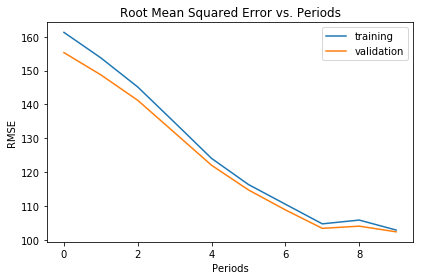

In [8]:
%matplotlib inline
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [9]:
# 线性缩放至[-1,1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [10]:
# 使用线性缩放将特征标准化
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

In [11]:
# 划分数据集
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

Training model...
RMSE (on training data):
  period 00 : 232.84
  period 01 : 212.74
  period 02 : 169.51
  period 03 : 120.87
  period 04 : 115.94
  period 05 : 112.33
  period 06 : 108.20
  period 07 : 103.39
  period 08 : 97.39
  period 09 : 90.80
Model training finished.
Final RMSE (on training data):   90.80
Final RMSE (on validation data): 90.20


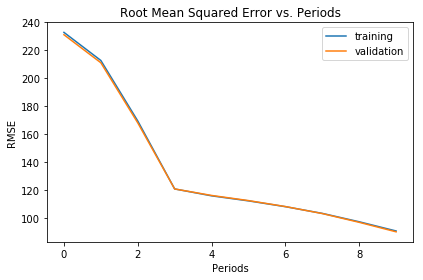

In [12]:
# 使用线性缩放过的特征进行训练
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 69.04
  period 01 : 69.02
  period 02 : 65.59
  period 03 : 64.72
  period 04 : 63.85
  period 05 : 64.40
  period 06 : 62.92
  period 07 : 65.31
  period 08 : 62.82
  period 09 : 62.21
Model training finished.
Final RMSE (on training data):   62.21
Final RMSE (on validation data): 61.29


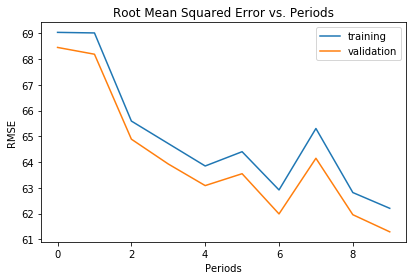

In [14]:
# 尝试 AdaGrad 和 Adam 优化器
# AdaGrad 的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。
# AdaGrad 优化器对于凸优化问题非常有效，但不一定适合非凸优化问题的神经网络训练，需使用较大学习率
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 70.23
  period 01 : 68.75
  period 02 : 68.38
  period 03 : 67.84
  period 04 : 66.16
  period 05 : 66.07
  period 06 : 65.03
  period 07 : 64.14
  period 08 : 63.75
  period 09 : 63.38
Model training finished.
Final RMSE (on training data):   63.38
Final RMSE (on validation data): 62.25


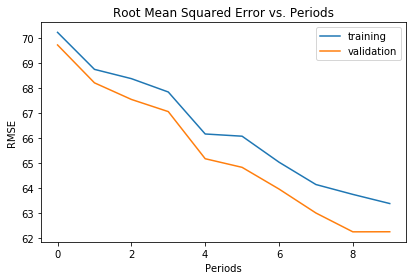

In [15]:
# 对于非凸优化问题，Adam 有时比 AdaGrad 更有效。
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

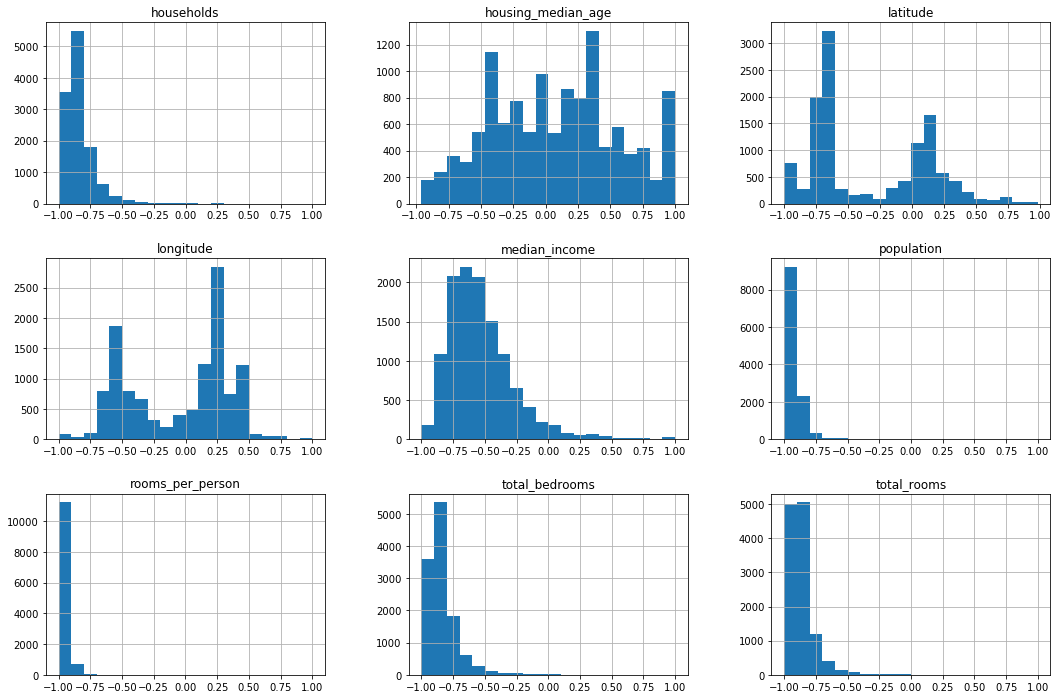

In [34]:
# 查看线性缩放后的数据 bins指定多少个柱状 figsize指画图区域大小
# 可以观察到某些特征进行线性缩放会使其聚集到接近 -1 的位置。
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12))

In [35]:
# 对数缩放、截取极端值
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

Training model...
RMSE (on training data):
  period 00 : 223.68
  period 01 : 157.16
  period 02 : 113.61
  period 03 : 111.96
  period 04 : 109.87
  period 05 : 107.17
  period 06 : 103.63
  period 07 : 99.31
  period 08 : 94.69
  period 09 : 90.08
Model training finished.
Final RMSE (on training data):   90.08
Final RMSE (on validation data): 90.41


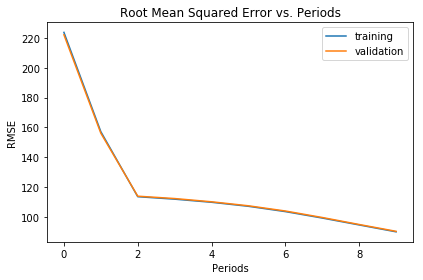

In [36]:
# 尝试除线性缩放外的其他标准化方法
def normalize(examples_dataframe):
  processed_features = pd.DataFrame()

 # 在对数空间呈现正态分布
  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
 # 线性缩放效果好
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

 # 有几个极端离群值
  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features


normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 105.80
  period 01 : 102.10
  period 02 : 100.67
  period 03 : 99.76
  period 04 : 99.18
  period 05 : 98.78
  period 06 : 98.83
  period 07 : 98.40
  period 08 : 98.03
  period 09 : 97.64
Model training finished.
Final RMSE (on training data):   97.64
Final RMSE (on validation data): 98.03


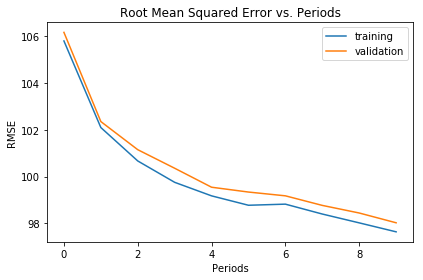

In [37]:
# 仅适用经度和纬度来作为特征训练模型、增加模型层数
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features
      
lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)
      
_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)